In [1]:
import os
import sys
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import mxnet as mx
from mxnet import nd, autograd as ag, gluon
from mxnet.gluon import nn
from mxnet import init
from mxnet import image

from dataloader import DataLoader

In [2]:
print("python: %r" % sys.version)
print("numpy: %r" % np.__version__)
#print("matplotlib: %r" % plt.__version__)
print("pandas: %r" % pd.__version__)
print("mxnet: %r" % mx.__version__)

python: '3.5.2 (default, Nov 23 2017, 16:37:01) \n[GCC 5.4.0 20160609]'
numpy: '1.15.1'
pandas: '0.23.4'
mxnet: '1.2.1'


# Config

In [3]:
ctx = mx.gpu(0)
batch_size = 50

# Data

## Self

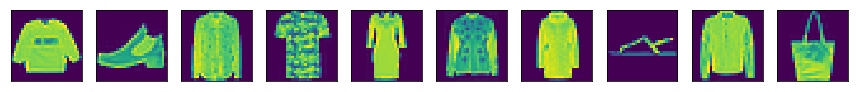

[['pullover'],
 ['ankle boot'],
 ['shirt'],
 ['t-shirt'],
 ['dress,'],
 ['coat'],
 ['coat'],
 ['sandal'],
 ['coat'],
 ['bag']]

In [4]:
dl = DataLoader(os.environ["HOME"] + '/.datasets/base/fashion-mnist/')
train_img,train_labels = dl.get_data(kind='train')
test_img,test_labels = dl.get_data(kind='t10k')

DataLoader.show_images(train_img[0:10])
DataLoader.get_labels(train_labels[0:10])

In [5]:
train_img.shape

(60000, 784)

In [6]:
# 修改为float以便求导，除以255做归一化
train_img_nd = nd.array(train_img).astype(np.float32)/255
train_lab_nd = nd.array(train_labels).astype(np.float32)
test_img_nd = nd.array(test_img).astype(np.float32)/255
test_lab_nd = nd.array(test_labels).astype(np.float32)

def data_iter(batch_size=100, kind='train'):
    if kind != 'train':
        idx = list(range(len(test_labels)))
        for i in range(0,len(test_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(test_labels))])
            yield nd.take(test_img_nd,j).as_in_context(ctx), nd.take(test_lab_nd,j).as_in_context(ctx)
    else:
        idx = list(range(len(train_labels)))
        for i in range(0,len(train_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(train_labels))])
            yield nd.take(train_img_nd,j).as_in_context(ctx), nd.take(train_lab_nd,j).as_in_context(ctx)

## Gluon

In [7]:
data_root = "~/.mxnet/datasets/fashion-mnist"
mnist_train = gluon.data.vision.FashionMNIST(root=data_root, train=True, transform=None)
mnist_test = gluon.data.vision.FashionMNIST(root=data_root, train=False, transform=None)

In [8]:
type(mnist_train)

mxnet.gluon.data.vision.datasets.FashionMNIST

**FashionMNIST 使用方法：** 

mnist_train/test 可以这样访问：

- `mnist_train[0]` : ([28,28,1],label)
- `mnist_train[0:10]`: ([10,28,28,1], (10,)) —— **为什么要这么玩**
- 支持 iter 访问

In [9]:
a = mnist_train[0]
print(type(a),type(a[0]),type(a[1]),a[0].shape,a[1].shape)

<class 'tuple'> <class 'mxnet.ndarray.ndarray.NDArray'> <class 'numpy.int32'> (28, 28, 1) ()


In [10]:
b = mnist_train[0:10]
print(type(b),type(b[0]),type(b[1]),b[0].shape,b[1].shape)

<class 'tuple'> <class 'mxnet.ndarray.ndarray.NDArray'> <class 'numpy.ndarray'> (10, 28, 28, 1) (10,)


In [11]:
b[0].shape

(10, 28, 28, 1)

In [12]:
c = nd.transpose(b[0].astype('float32'), (0,3,1,2)) # 0,3,1,2 意思是原来的位置，如何放到现在的位置
c.shape

(10, 1, 28, 28)

(10, 1, 28, 28)： 整理成 nd.Convolution(data) 中 data 的格式，data（即图片）要求格式是：  
(batchsize, channel, height, width)

# Model

## Net

$$\boldsymbol{\hat y} = net({\boldsymbol x})$$

In [13]:
num_input = 28*28
num_output = 10

### Wb

无隐层

$$net({\boldsymbol x}) = {\boldsymbol{x}}\ {W} + {\boldsymbol{b}}$$

In [14]:
W = nd.random_normal(shape=(num_input, num_output),ctx=ctx)
b = nd.random_normal(shape=(num_output),ctx=ctx)

wb_params = [W,b]
for p in wb_params:
    p.attach_grad()

In [15]:
def net_wb(X):
    return nd.dot(X,W) + b

### MLP

加入1个隐层

In [16]:
def relu(X):
    return nd.maximum(X,0)

In [17]:
num_hidden = 256
weight_scale = .01

# MXNet 的公式是 y=XW+b，吴恩达的公式是 y=WX+b，所以两者W的shape定义是相反的。
W1 = nd.random_normal(shape=(num_input,num_hidden), scale=weight_scale,ctx=ctx)
b1 = nd.zeros(num_hidden,ctx=ctx)

W2 = nd.random_normal(shape=(num_hidden,num_output),scale=weight_scale,ctx=ctx)
b2 = nd.zeros(num_output,ctx=ctx)

mlp_params = [W1,b1,W2,b2]
for p in mlp_params:
    p.attach_grad()

In [18]:
def net_mlp(X):
    X = X.reshape((-1, num_input))
    h1 = relu(nd.dot(X,W1) + b1)
    output = nd.dot(h1,W2) + b2
    return output

### MLP_gluon

In [19]:
mlp_net = gluon.nn.Sequential()
with mlp_net.name_scope():
    mlp_net.add(gluon.nn.Dense(256, activation="relu"))
    mlp_net.add(gluon.nn.Dropout(0.5))
    mlp_net.add(gluon.nn.Dense(10))
mlp_net.initialize(ctx=ctx)

In [20]:
def net_mlp_gluon(X):
    return mlp_net(X)

### LeNet

In [21]:
weight_scale = .01

# output channels = 20, kernel = (5,5)
lenet_W1 = nd.random_normal(shape=(20,1,5,5), scale=weight_scale, ctx=ctx)
lenet_b1 = nd.zeros(lenet_W1.shape[0], ctx=ctx)

# output channels = 50, kernel = (3,3)
lenet_W2 = nd.random_normal(shape=(50,20,3,3), scale=weight_scale, ctx=ctx)
lenet_b2 = nd.zeros(lenet_W2.shape[0], ctx=ctx)

# output dim = 128
lenet_W3 = nd.random_normal(shape=(1250, 128), scale=weight_scale, ctx=ctx)
lenet_b3 = nd.zeros(lenet_W3.shape[1], ctx=ctx)

# output dim = 10
lenet_W4 = nd.random_normal(shape=(lenet_W3.shape[1], 10), scale=weight_scale, ctx=ctx)
lenet_b4 = nd.zeros(lenet_W4.shape[1], ctx=ctx)

lenet_params = [lenet_W1, lenet_b1, lenet_W2, lenet_b2, lenet_W3, lenet_b3, lenet_W4, lenet_b4]
for param in lenet_params:
    param.attach_grad()

In [22]:
def net_lenet(X, verbose=False):    
    # 第一层卷积
    h1_conv = nd.Convolution(
        data=X, weight=lenet_W1, bias=lenet_b1, kernel=lenet_W1.shape[2:], num_filter=lenet_W1.shape[0])
    h1_activation = nd.relu(h1_conv)
    h1 = nd.Pooling(
        data=h1_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    # 第二层卷积
    h2_conv = nd.Convolution(
        data=h1, weight=lenet_W2, bias=lenet_b2, kernel=lenet_W2.shape[2:], num_filter=lenet_W2.shape[0])
    h2_activation = nd.relu(h2_conv)
    h2 = nd.Pooling(data=h2_activation, pool_type="max", kernel=(2,2), stride=(2,2))
    h2 = nd.flatten(h2)
    # 第一层全连接
    h3_linear = nd.dot(h2, lenet_W3) + lenet_b3
    h3 = nd.relu(h3_linear)
    # 第二层全连接
    h4_linear = nd.dot(h3, lenet_W4) + lenet_b4
    if verbose:
        print('1st conv block:', h1.shape)
        print('2nd conv block:', h2.shape)
        print('1st dense:', h3.shape)
        print('2nd dense:', h4_linear.shape)
        print('output:', h4_linear)
    return h4_linear

### LeNet_gluon

In [23]:
lenet = nn.Sequential()
with lenet.name_scope():
    lenet.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )
lenet.initialize(ctx=ctx)

In [24]:
def net_lenet_gluon(X):
    return lenet(X)

### VGG_gluon

In [25]:
arch_A = ((1,64),(1,128),(2,256),(2,512),(2,512))
arch_B = ((2,64),(2,128),(2,256),(2,512),(2,512))
arch_D = ((2,64),(2,128),(3,256),(3,512),(3,512))
arch_E = ((2,64),(2,128),(4,256),(4,512),(4,512))

def vgg_stack(arch):
    out = nn.Sequential()
    for (num_convs, channels) in arch:
        seq = nn.Sequential()
        for _ in range(num_convs):
            seq.add(nn.Conv2D(channels=channels,kernel_size=3,
                          padding=1,activation='relu'))
        seq.add(nn.MaxPool2D(pool_size=2, strides=2))
        out.add(seq)
    return out
    
vgg_net = nn.Sequential()
with vgg_net.name_scope():
    vgg_net.add(
        vgg_stack(arch_A),
        nn.Flatten(),
        nn.Dense(4096, activation='relu'),
        nn.Dropout(0.5),
        nn.Dense(4096, activation='relu'),
        nn.Dropout(0.5),
        nn.Dense(10))
vgg_net.initialize(ctx=ctx, init=init.Xavier())

In [26]:
def net_vgg_gluon(X):
    return vgg_net(X)

### **net( )**

In [27]:
# data shape: (batchsize, height, width, channel)
# out  shape: (batchsize, channel, height, width)
def resize_img(data, resize=None):
    if resize:
        n = data.shape[0]
        new_data = nd.zeros((n, resize, resize, data.shape[3]))
        for i in range(n):
            new_data[i] = image.imresize(data[i].as_in_context(mx.cpu()), 
                                         resize, resize)
        data = new_data
    return nd.transpose(data.astype('float32'),(0,3,1,2))/255

In [28]:
def net(data, net_type='wb'):
    data = data.as_in_context(ctx)
    # data.shape: 100*784
    if net_type == 'wb':
        return net_wb(data)
    elif net_type == 'mlp':
        return net_mlp(data)
    elif net_type == 'mlp_gluon':
        return net_mlp_gluon(data)
    elif net_type == 'lenet':
        data = data.reshape((data.shape[0],1,28,28))
        return net_lenet(data.astype('float32'))
    elif net_type == 'lenet_gluon':
        data = data.reshape((data.shape[0],1,28,28))
        return net_lenet_gluon(data.astype('float32'))
    elif net_type == 'vgg_gluon':
        data = data.reshape((data.shape[0],28,28,1))
        data = resize_img(data, resize=96)
        data = data.as_in_context(ctx)
        return net_vgg_gluon(data.astype('float32'))
    else:
        return None

## Loss

### Self

$$softmax(\mathbf{z})_j = \frac{e^{z_j}}{\sum_{k=1}^K e^{z_k}}$$

In [29]:
def softmax(X):
    e = nd.exp(X)
    t = nd.sum(e, axis=1, keepdims=True)
    return e/t

交叉熵 Cross Entropy: 

$$-\sum_i \log p_{i,{label}_i}$$

In [30]:
def cross_entropy(yhat,y):
    # yhat数组（10个元素）中取出索引为 y 的那个元素
    # rt = - nd.log(nd.pick(yhat,y)) 
    rt = - nd.pick(nd.log(yhat),y)
    rt = nd.mean(rt, axis=0, exclude=True)
    return rt

### Gluon

gluon.loss.xxx

- L1Loss: $$L = \sum_i \vert {pred}_i - {label}_i \vert.$$
- L2Loss: $$L = \frac{1}{2} \sum_i \vert {pred}_i - {label}_i \vert^2.$$
- SigmoidBinaryCrossEntropyLoss: $$\begin{align}\begin{aligned}prob = \frac{1}{1 + \exp(-{pred})}\\L = - \sum_i {label}_i * \log({prob}_i) + (1 - {label}_i) * \log(1 - {prob}_i)\end{aligned}\end{align}$$
- SoftmaxCrossEntropyLoss: $$\begin{align}\begin{aligned}\DeclareMathOperator{softmax}{softmax}\\p = \softmax({pred})\\L = -\sum_i \log p_{i,{label}_i}\end{aligned}\end{align}$$
- KLDivLoss: $$L = \sum_i {label}_i * \big[\log({label}_i) - {pred}_i\big]$$
- CTCLoss
- HuberLoss
- HingeLoss
- SquaredHingeLoss
- LogisticLoss:$$L = \sum_i \log(1 + \exp(- {pred}_i \cdot {label}_i))$$
- TripletLoss

In [31]:
loss_softmax_ce = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimizer/Trainner

### Self

In [32]:
def SGD(params, lr):
    for p in params:
        p[:] = p - lr*p.grad

In [33]:
sgd = mx.optimizer.SGD()

### Gluon

In [34]:
def get_trainer(net):
    return gluon.Trainer(net.collect_params(), 
                        'sgd', 
                        {'learning_rate': 0.5})

# Evaluation

In [35]:
def accuracy(yhat,y):
    return nd.mean(yhat.argmax(axis=1)==y).asscalar()

# Train

In [36]:
def train(epochs=5, learning_rate=.1, net_type='wb', params=wb_params, trainer=None):
    t1 = datetime.datetime.now()
    prev_time = datetime.datetime.now()
    for e in range(epochs):
        train_loss = 0.
        train_accu = 0.
        test_accu  = 0.

        i = 0
        for data,label in data_iter(batch_size=batch_size):
            i += 1
            print('\r%4d %d%%' % (i, 100*i/(train_img.shape[0]/batch_size)), end='')
            with ag.record():
                yhat = net(data, net_type)
                # 首选mxnet的loss：
                # mxnet的loss，W、b的均值不变、方差变小
                # 自己手写的loss会让W、b的均值单调递增，最后变为nan —— learning rate 小一点可以拖后变nan的次数，但早晚也是变nan
                if 1:
                    loss = loss_softmax_ce(yhat,label)
                else:
                    loss  = cross_entropy(softmax(yhat),label)
            loss.backward()
            if trainer == None:
                SGD(params, learning_rate/batch_size)
            else:
                trainer.step(batch_size)
            train_loss += nd.mean(loss).asscalar()
            train_accu += accuracy(yhat,label)
        #print("\r\nyhat sum:%f, var:%f, mean:%f" % (np.sum(yhat.asnumpy()), np.var(yhat.asnumpy()), np.mean(yhat.asnumpy())))
        #print("W sum:%f, var:%f, mean:%f" % (np.sum(W.asnumpy()), np.var(W.asnumpy()), np.mean(W.asnumpy())))
        #print("b sum:%f, var:%f, mean:%f" % (np.sum(b.asnumpy()), np.var(b.asnumpy()), np.mean(b.asnumpy())))

        for data,label in data_iter(batch_size=batch_size,kind='test'):
            data  = data.as_in_context(ctx)
            label = label.as_in_context(ctx)
            yhat = net(data, net_type)
            test_accu += accuracy(yhat, label)
                
        cur_time = datetime.datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        prev_time = cur_time
        
        print("\r%s epoch:%d; loss:%f; Train accu:%f; Test accu:%f; Time:%s" % (
                        net_type, e, 
                        train_loss/len(train_labels)*batch_size,
                        train_accu/len(train_labels)*batch_size,
                        test_accu/len(test_labels)*batch_size,
                        time_str))

    print(datetime.datetime.now()-t1)

In [37]:
train(net_type='wb', params=wb_params, epochs=10)

wb epoch:0; loss:1.990911; Train accu:0.632633; Test accu:0.723500; Time:Time 00:00:01
wb epoch:1; loss:1.134481; Train accu:0.743483; Test accu:0.758300; Time:Time 00:00:01
wb epoch:2; loss:0.961380; Train accu:0.769050; Test accu:0.777200; Time:Time 00:00:01
wb epoch:3; loss:0.866320; Train accu:0.781950; Test accu:0.787200; Time:Time 00:00:01
wb epoch:4; loss:0.802320; Train accu:0.791517; Test accu:0.794900; Time:Time 00:00:01
wb epoch:5; loss:0.754979; Train accu:0.798200; Test accu:0.798700; Time:Time 00:00:01
wb epoch:6; loss:0.718040; Train accu:0.804000; Test accu:0.803100; Time:Time 00:00:01
wb epoch:7; loss:0.688148; Train accu:0.808567; Test accu:0.807000; Time:Time 00:00:01
wb epoch:8; loss:0.663303; Train accu:0.811733; Test accu:0.808900; Time:Time 00:00:01
wb epoch:9; loss:0.642239; Train accu:0.815017; Test accu:0.811000; Time:Time 00:00:01
0:00:16.242213


In [38]:
train(net_type='mlp', params=mlp_params)

mlp epoch:0; loss:0.652557; Train accu:0.765483; Test accu:0.834900; Time:Time 00:00:02
mlp epoch:1; loss:0.435276; Train accu:0.842683; Test accu:0.855800; Time:Time 00:00:02
mlp epoch:2; loss:0.389818; Train accu:0.859283; Test accu:0.866800; Time:Time 00:00:02
mlp epoch:3; loss:0.362056; Train accu:0.868283; Test accu:0.874600; Time:Time 00:00:02
mlp epoch:4; loss:0.341983; Train accu:0.875867; Test accu:0.880500; Time:Time 00:00:02
0:00:10.255691


In [39]:
train(net_type='mlp_gluon',trainer=get_trainer(mlp_net))

mlp_gluon epoch:0; loss:0.918494; Train accu:0.651183; Test accu:0.760200; Time:Time 00:00:01
mlp_gluon epoch:1; loss:0.714639; Train accu:0.726967; Test accu:0.786400; Time:Time 00:00:02
mlp_gluon epoch:2; loss:0.656104; Train accu:0.754450; Test accu:0.835300; Time:Time 00:00:02
mlp_gluon epoch:3; loss:0.613184; Train accu:0.772083; Test accu:0.780600; Time:Time 00:00:01
mlp_gluon epoch:4; loss:0.594230; Train accu:0.781583; Test accu:0.817800; Time:Time 00:00:01
0:00:09.941778


In [40]:
train(net_type='lenet', params=lenet_params)

lenet epoch:0; loss:1.507709; Train accu:0.418667; Test accu:0.771100; Time:Time 00:00:06
lenet epoch:1; loss:0.510878; Train accu:0.807533; Test accu:0.858800; Time:Time 00:00:06
lenet epoch:2; loss:0.395434; Train accu:0.854750; Test accu:0.872800; Time:Time 00:00:06
lenet epoch:3; loss:0.345393; Train accu:0.873133; Test accu:0.880500; Time:Time 00:00:06
lenet epoch:4; loss:0.315531; Train accu:0.884317; Test accu:0.882800; Time:Time 00:00:06
0:00:33.791102


In [41]:
train(net_type='lenet_gluon', trainer=get_trainer(lenet))

lenet_gluon epoch:0; loss:0.563640; Train accu:0.789850; Test accu:0.868200; Time:Time 00:00:06
lenet_gluon epoch:1; loss:0.348757; Train accu:0.869317; Test accu:0.883600; Time:Time 00:00:06
lenet_gluon epoch:2; loss:0.309822; Train accu:0.883717; Test accu:0.888100; Time:Time 00:00:06
lenet_gluon epoch:3; loss:0.285167; Train accu:0.892317; Test accu:0.888800; Time:Time 00:00:06
lenet_gluon epoch:4; loss:0.268244; Train accu:0.898000; Test accu:0.890300; Time:Time 00:00:06
0:00:32.280320


In [42]:
train(net_type='vgg_gluon', trainer=get_trainer(vgg_net), epochs=1)

   1 0%

MXNetError: [19:09:27] src/storage/./pooled_storage_manager.h:108: cudaMalloc failed: out of memory

Stack trace returned 10 entries:
[bt] (0) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x31f81a) [0x7f7f345d781a]
[bt] (1) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x31fe41) [0x7f7f345d7e41]
[bt] (2) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x29eea63) [0x7f7f36ca6a63]
[bt] (3) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x29f3315) [0x7f7f36cab315]
[bt] (4) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x459114) [0x7f7f34711114]
[bt] (5) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2508b0d) [0x7f7f367c0b0d]
[bt] (6) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2508fe3) [0x7f7f367c0fe3]
[bt] (7) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2480fbd) [0x7f7f36738fbd]
[bt] (8) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2480fa7) [0x7f7f36738fa7]
[bt] (9) /home/kevin/workspace/pyvenv/py3venv/lib/python3.5/site-packages/mxnet/libmxnet.so(+0x2480fa7) [0x7f7f36738fa7]



# Test

In [ ]:
from statiser import Statistics

In [ ]:
#P310 上运行需要很长时间，且会跑死
#vgg_net.load_parameters("/home/kevin/Downloads/devlab.zte/vgg-net-params-2018-08-31_18-20-37", ctx=ctx)

In [ ]:
train_lab_nd[:10].asnumpy()

In [ ]:
net(train_img_nd[:10],net_type='mlp').argmax(axis=1).asnumpy()

In [ ]:
from statiser import Statistics

tr1 = Statistics(net(train_img_nd,net_type='wb').argmax(axis=1).asnumpy(), train_lab_nd.asnumpy())
tr1.show()
tr2 = Statistics(net(train_img_nd,net_type='mlp').argmax(axis=1).asnumpy(), train_lab_nd.asnumpy())
tr2.show()
tr3 = Statistics(net(train_img_nd,net_type='mlp_gluon').argmax(axis=1).asnumpy(), train_lab_nd.asnumpy())
tr3.show()
tr4 = Statistics(net(train_img_nd[:100],net_type='lenet').argmax(axis=1).asnumpy(), train_lab_nd[:100].asnumpy())
tr4.show()

te1 = Statistics(net(test_img_nd,net_type='wb').argmax(axis=1).asnumpy(), test_lab_nd.asnumpy())
te1.show()
te2 = Statistics(net(test_img_nd,net_type='mlp').argmax(axis=1).asnumpy(), test_lab_nd.asnumpy())
te2.show()
te3 = Statistics(net(test_img_nd,net_type='mlp_gluon').argmax(axis=1).asnumpy(), test_lab_nd.asnumpy())
te3.show()
te4 = Statistics(net(test_img_nd[:100],net_type='lenet').argmax(axis=1).asnumpy(), test_lab_nd[:100].asnumpy())
te4.show()

plt.plot(range(10),tr1.Recall(),'r')
plt.plot(range(10),tr1.Precision(),'g')
plt.plot(range(10),te1.Recall(),'b')
plt.plot(range(10),te1.Precision(),'k')
plt.show()